# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [4]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [5]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [6]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.8
cachedir: .pytest_cache
rootdir: /root/udacity-deeplearning/convolutional-neural-networks/project
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
../../../../opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11
  /opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
    warn(f"Failed to load image Python extension: {e}")

src/transfer.py::test_get_model_transfer_learning
src/transfer.py::test_get_model_transfer_learning
  /opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/utils.py:184: DeprecationWarning: invalid 

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [39]:
batch_size = 30  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 35  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0007125678957192841 # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0007861347900869156 # regularization. Increase this to combat overfitting

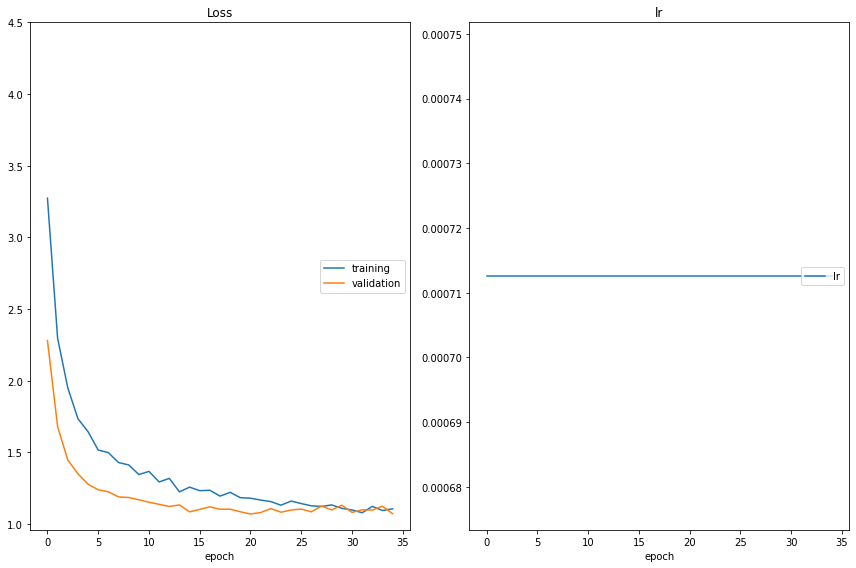

1.0704160998849308

In [40]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_name = 'resnext50_32x4d'
# resnet50
# resnext50_32x4d

model_transfer = get_model_transfer_learning(model_name, num_classes) # YOUR CODE HERE

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ I decided to choose ResNeXt, since that was the one that led to the best results. I started from ResNet18, but I wanted to try out architectures having more layers, as those would tend to capture more features, so my next step was ResNet50. Then, I wanted to try out more modern architectures, leading me to be ResNeXt, which had improved the results. I'd like to have gone futher, looking at ConvNeXt, and also at models pretrained on datasets more similar to landmarks, but none of that was easily available. Fortunately, ImageNet led to a reasonable good job.


Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

In [ ]:
# Initial experiment results

# (1) resnet18,  default hyperparameters, 25 epochs: 
# Training Accuracy: 66.68%
# Validation Accuracy: 68.13%
# Loss: 1.1645239405333998

# (2) resnet50  default hyperparameters, 25 epochs: 
# Training Accuracy: 71.69%
# Validation Accuracy: 73.01%

# (3) resnext  default hyperparameters, 25 epochs: 
# Training Accuracy: 72.02%
# Validation Accuracy: 73.61%
# Loss: 1.0260833427309988

#### HyperParameter Optimization

In [ ]:
# !pip install  sqlalchemy==2.0.0rc2  optuna | grep -v "already satisfied"

!pip install  sqlalchemy==1.4.8  optuna | grep -v "already satisfied"

In [ ]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel
import torch
from sqlalchemy import orm
import optuna
import torchvision.models as models
from src.transfer import get_model_transfer_learning

torch.cuda.empty_cache()

valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 20        # number of epochs for training
num_classes = 50       # number of classes. Do not change this

model_name = 'resnext50_32x4d'

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    weight_decay = trial.suggest_uniform('weight_decay', 0, 1e-3)
    opt = trial.suggest_categorical('opt', ['sgd', 'adam'])
    momentum = trial.suggest_uniform('momentum', 0.1, 0.9)
    batch_size = trial.suggest_int('batch_size', 2, 64)

    print(f'Starting trial {trial.number}:\tHyperparameters={trial.params}')         
    
    model_transfer = get_model_transfer_learning(model_name, num_classes) 

    # train the model
    data_loaders = get_data_loaders(batch_size=batch_size)
    optimizer = get_optimizer(
        model_transfer,
        learning_rate=learning_rate,
        momentum=momentum,
        optimizer=opt,
        weight_decay=weight_decay,
    )
    loss = get_loss()

    valid_loss_min = optimize(
        data_loaders,
        model_transfer,
        optimizer,
        loss,
        n_epochs=num_epochs,

        save_path=f"checkpoints/hpo_{trial.number}_model_transfer.pt",
        interactive_tracking=False
    )

    return valid_loss_min
    
# Define study and optimize hyperparameters
study = optuna.create_study(direction='minimize')

# Set starting point
trial_params = {
    'learning_rate': 0.0021832609077478055, 
    'momentum': 0.47627501792157945, 
    'batch_size': 5, 
    'opt': 'sgd'} 

study.enqueue_trial(trial_params)

study.optimize(objective, n_trials=20)


In [33]:
print('Best hyperparameters:', study.best_params)
print('Loss value:', study.best_value)

Best hyperparameters: {'learning_rate': 0.0007125678957192841, 'weight_decay': 0.0007861347900869156, 'opt': 'adam', 'momentum': 0.41508530498861795, 'batch_size': 30}
Loss value: 0.9371721253675572


In [ ]:
#  HPO

# Trial 0 finished with value: 1.2281074883481167 and parameters: {'learning_rate': 0.0021832609077478055, 'weight_decay': 0.00032202437939391794, 'opt': 'sgd', 'momentum': 0.47627501792157945, 'batch_size': 5}. Best is trial 0 with value: 1.2281074883481167.
#  Best is trial 2 with value: 0.9371721253675572 - Hyperparameters={'learning_rate': 0.0007125678957192841, 'weight_decay': 0.0007861347900869156, 'opt': 'adam', 'momentum': 0.41508530498861795, 'batch_size': 30}

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [41]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning(model_name, n_classes=num_classes)

# Load saved weights
# model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))
checkpoint = torch.load('checkpoints/model_transfer.pt')
model_transfer.load_state_dict(checkpoint['model_state_dict'])

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]

Test Loss: 0.918417


Test Accuracy: 76% (950/1250)


0.9184167385101318

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [42]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")['model_state_dict']
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [01:31<00:00, 13.68it/s]


Accuracy: 0.7424


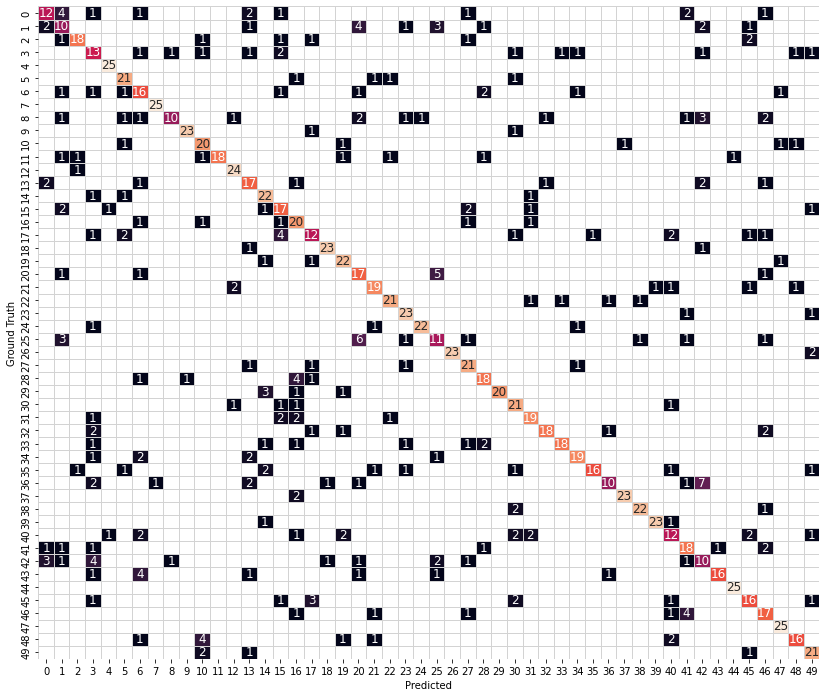

In [43]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)